In [1]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax

import numpy as np
import matplotlib.pyplot as plt
import sys
from skimage.io import imread, imsave

from os import listdir, makedirs
from os.path import isfile, join, isdir

%matplotlib inline


In [2]:
import scipy.io as sio
from skimage import color
import os

In [3]:
image_data = '/data2/arunirc/Research/FlowNet2/flownet2-docker/data/complexBackground/complexBackground-multilabel/'
seg_data = '/data/pbideau/motionSegmentation/Aruni_CRF/complex-background-multi-labels/'
image_exts = ['.jpg', '.png']

out_dir = 'data/crf-output/complex-bg'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [24]:
# function definitions

def preprocess_label_scores(res):
    '''
        labels, label_map, n_labels = preprocess_label_scores(res)
            Pre-processes the objectness scores from Pia's code.
            Only the labels with non-zero presence are retained.
            So the `res` HxWxK tensor becomes HxWxC, where C<=K.
            Then it is re-arranged to CxHxW.
    '''
    res_sum = np.squeeze(np.sum(np.sum(res, axis=0), axis=0))
    label_map = np.array(np.where(res_sum > 0)[0])
    labels = np.squeeze(res[:,:,label_map]) # keep non-zero presence labels
    assert np.abs(np.sum(labels) - res.shape[0]*res.shape[1]) < np.finfo(np.float32).eps # check probability
    labels = np.transpose(labels, (2,0,1)) # C x H x W
    n_labels = len(label_map)
    return labels, label_map, n_labels


In [62]:

for d in sorted(listdir(image_data)):
    vid_dir = join(image_data, d)
    if not isdir(vid_dir):
        continue
    print d
    seg_dir = join(seg_data, d, 'GroundTruth/objectProb/')
    
    if not os.path.isdir(join(out_dir, d)):
        os.makedirs(join(out_dir, d))
        
    if not os.path.isdir(join(out_dir, d, 'viz')):
        os.makedirs(join(out_dir, d, 'viz'))
    
    for frame in sorted(listdir(vid_dir)):
        if frame.endswith(tuple(image_exts)):
            
            frame_name = str.split(frame, '.')[0]
            frame_num = str.split(frame_name, '_')[1]   
            
            # read motion segmentation result (MAT file)
            seg_file = join(seg_dir, frame_num+'.mat')
            if not isfile(seg_file):
                continue  # there is one less seg-file than frames
            mat_data = sio.loadmat(seg_file)
            res = mat_data['objectProb']
            
            # read RGB image
            img = imread(join(vid_dir, frame))
            
            # input probabilities
            labels, label_map, n_labels = preprocess_label_scores(res)
            
            # Dense CRF inference
            crf = dcrf.DenseCRF(img.shape[1] * img.shape[0], n_labels)
            U = unary_from_softmax(labels)
            crf.setUnaryEnergy(U)
            feats = create_pairwise_gaussian(sdims=(3, 3), shape=img.shape[:2])
            crf.addPairwiseEnergy(feats, compat=3,
                            kernel=dcrf.DIAG_KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)
            feats = create_pairwise_bilateral(sdims=(50, 50), schan=(10, 10, 10),
                                          img=img, chdim=2)
            crf.addPairwiseEnergy(feats, compat=5,
                            kernel=dcrf.DIAG_KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)
            Q = crf.inference(5)
            
            # CRF scores into Pia's format
            probQ = np.array(Q)
            crf_prob = probQ.reshape((probQ.shape[0], img.shape[0] ,img.shape[1]))
            crf_prob = crf_prob.transpose((1,2,0))
            crf_out_final = np.zeros(res.shape)
            crf_out_final[:,:,label_map] = crf_prob
            
            # save as matlab MATLAB-style .mat file
            sio.savemat(join(out_dir, d, frame_num+'.mat'), \
                        dict(objectProb=crf_out_final))
            
            
            # CRF MAP labels
            MAP = np.argmax(Q, axis=0) 
            crf_map_img = MAP.reshape((img.shape[0], img.shape[1]))
            crf_label_img = label_map[crf_map_img] # CRF labels --> instance labels
            
            # side-by-side visualizations as RGB overlays
            crf_rgb = color.label2rgb(crf_label_img, img)
            res_label =  np.argmax(res, axis=2)
            res_rgb = color.label2rgb(res_label, img)
            tiled_img = np.concatenate((res_rgb, \
                            np.zeros([res_rgb.shape[0],10,3]), \
                            crf_rgb), axis=1)
            imsave(join(out_dir, d, 'viz', frame_num+'_raw_crf.png'), tiled_img)
            

drive
forest
parking
store
traffic


In [29]:
probQ.shape

(3, 307200)

In [30]:
probQ.shape[0]

3

In [32]:
print img.shape[0]
print img.shape[1]

480
640


In [33]:
print img.shape[0] * img.shape[1]

307200


In [46]:
res.shape

(480, 640, 5)

In [47]:
label_map

array([0, 1, 4])

In [38]:
crf_prob = probQ.reshape((probQ.shape[0], img.shape[0] ,img.shape[1]))
crf_prob = crf_prob.transpose((1,2,0))

In [39]:
crf_prob.shape

(480, 640, 3)

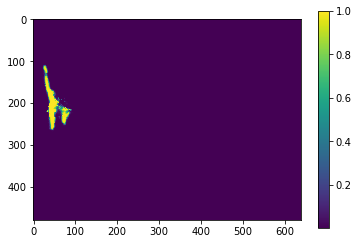

In [45]:
plt.imshow(crf_prob[:,:,2])
plt.colorbar()

In [51]:

crf_out_final = np.zeros(res.shape)
print crf_out_final.shape
crf_out_final[:,:,label_map] = crf_prob


(480, 640, 5)


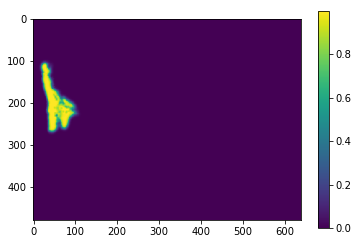

In [64]:
plt.imshow(res[:,:,4])
plt.colorbar()

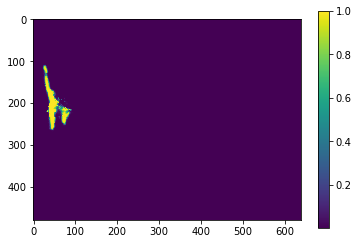

In [63]:
plt.imshow(crf_out_final[:,:,4])
plt.colorbar()

In [64]:
res = mat_data['objectProb']

print res.shape

res_sum = np.squeeze(np.sum(np.sum(res, axis=0), axis=0))
label_map = np.where(res_sum > 0)[0]
print label_map
print res_sum

labels = np.squeeze(res[:,:,label_map])
assert np.sum(labels, axis=2) == res.shape[0]*res.shape[1] # check probability

sum_labels = np.sum(labels, axis=2)

labels = np.transpose(labels, (2,0,1))

label_map = np.array(label_map)
n_labels = len(label_map)

[0 1 4]
[ 295861.44098636    5946.33578639       0.               0.
    5392.22322726]
[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


3

In [14]:
crf = dcrf.DenseCRF(img.shape[1] * img.shape[0], n_labels)

U = unary_from_softmax(labels)
crf.setUnaryEnergy(U)

feats = create_pairwise_gaussian(sdims=(3, 3), shape=img.shape[:2])
crf.addPairwiseEnergy(feats, compat=3,
                kernel=dcrf.DIAG_KERNEL,
                normalization=dcrf.NORMALIZE_SYMMETRIC)

feats = create_pairwise_bilateral(sdims=(50, 50), schan=(10, 10, 10),
                              img=img, chdim=2)
crf.addPairwiseEnergy(feats, compat=5,
                kernel=dcrf.DIAG_KERNEL,
                normalization=dcrf.NORMALIZE_SYMMETRIC)

In [15]:
Q = crf.inference(5)

probQ = np.array(Q)

MAP = np.argmax(Q, axis=0)

map_img = MAP.reshape((img.shape[0], img.shape[1]))

In [16]:
np.unique(map_img)

array([0, 1, 2])

In [17]:
orig_label_map_img =label_map[map_img]

In [18]:
np.unique(orig_label_map_img)

array([0, 1, 4])

In [19]:


crf_rgb = color.label2rgb(orig_label_map_img, img)

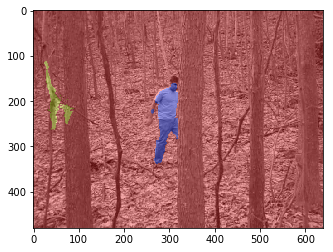

In [7]:
plt.imshow(crf_rgb)

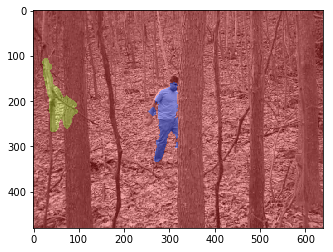

In [6]:
res_label =  np.argmax(res, axis=2)
res_rgb = color.label2rgb(res_label, img)
plt.imshow(res_rgb)

In [23]:
np.unique(res_label)

array([0, 1, 4])

In [20]:
tiled_img = np.concatenate((res_rgb, np.zeros([res_rgb.shape[0],10,3]) ,crf_rgb), axis=1)

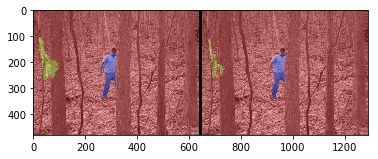

In [21]:
plt.imshow(tiled_img)

In [15]:
np.zeros([2,10]).shape

(2, 10)